In [1]:
import numpy as np
import pandas as pd

In [2]:
import re 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
headers=["Text","Status"]

In [5]:
df = pd.read_csv("new_sales_extended.csv",header=None,encoding='cp850')
df.drop([2,3],axis=1,inplace=True)
df.columns = headers

In [6]:
df['Status'].value_counts()

1    1712
0    1381
Name: Status, dtype: int64

In [7]:
df.head()

,Text,Status
0,Could you please approve this project for {{Da...,0
1,"Hey, I just got your msg from Friday. I left ...",0
2,Can you give more details or email the plan pr...,0
3,"Hi {{Name}}, Just a quick follow up here about...",1
4,"Hi,\nYou are really are patient ??\nSo what yo...",1


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Status'], random_state=0, train_size = .90)

In [9]:
X_test

2305    Here is the wh data.  I have included the file...
1114                        Follow up with me in a month?
2593    Hi Gaurav, Thanks for reaching out. I have att...
989     We would love to jump on a quick call to discu...
678                    {{Name}} and I would love to come.
                              ...                        
2641    Hi {{Name}}, Thanks for reaching out. To launc...
311     Please e-mail me if you would like to pick up ...
553     Hi Bilal, As per our prior conversation, find ...
2252    I need for you to find out how much the balanc...
2398    Please send the latest cost estimates when you...
Name: Text, Length: 310, dtype: object

In [10]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [11]:
train = pd.DataFrame(X_train)
test = pd.DataFrame(X_test)

In [12]:
X_train

,Text
716,"Dear Ayesha,\nI hope well. Please can you outl..."
189,Charts for today's briefing are attached
2158,"Weirdly enough, the link you sent was invalid ..."
618,\nThanks Verdi.
1931,"Hassaan,\nI have a client asking to meet at 3:..."
...,...
763,"\nHello Ahshan!\nMy name is Julia, I'm HR Mana..."
835,Did they write an article about us?\n
1653,"Hello {{Name}}, Thank you for getting back to ..."
2607,she told me you are not coming office tomorrow\n


In [13]:
vocab_size = 5000
max_len = 30

In [14]:
def clean(text):
    text = text.lower()
    text = re.sub("(http|https|www)(:|\.)\S+.com"," ",text)
    text = re.sub("[^\w\d]"," ",text)
    text = " ".join([t for t in text.split()])
    return text

In [15]:
X_train['Cleaned'] =  X_train['Text'].apply(lambda x : clean(x))

In [16]:
X_train.head()

,Text,Cleaned
716,"Dear Ayesha,\nI hope well. Please can you outl...",dear ayesha i hope well please can you outline...
189,Charts for today's briefing are attached,charts for today s briefing are attached
2158,"Weirdly enough, the link you sent was invalid ...",weirdly enough the link you sent was invalid b...
618,\nThanks Verdi.,thanks verdi
1931,"Hassaan,\nI have a client asking to meet at 3:...",hassaan i have a client asking to meet at 3 00...


In [17]:
token = Tokenizer(num_words=vocab_size)
token.fit_on_texts(X_train['Cleaned'])
X_train = token.texts_to_sequences(X_train['Cleaned'])

In [18]:
import pickle

# saving
with open('tokenizer_new.pickle', 'wb') as handle:
    pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
X_test = X_test['Text'].apply(lambda x : clean(x))
X_test = token.texts_to_sequences(X_test)

In [20]:
X_test = pad_sequences(X_test,padding='pre',truncating='pre',maxlen=max_len)

In [21]:
X_train = pad_sequences(X_train,maxlen=max_len,padding='pre',truncating='pre')

In [22]:
X_test

array([[813, 521,  30, ...,   2, 141, 813],
       [  0,   0,   0, ...,  10,   5, 136],
       [274, 439, 284, ...,  37,  79,  34],
       ...,
       [  2, 175,   5, ..., 152,  54, 124],
       [  0,   0,   0, ...,  36,  28,  33],
       [  0,   0,   0, ..., 222,  18, 301]])

In [23]:
model = Sequential([
    Embedding(vocab_size,100,input_length=max_len),
    Dropout(0.2),
    LSTM(200),
    Dropout(0.2),
    Dense(1,activation='sigmoid')
])

In [24]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           500000    
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 200)               240800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 741,001
Trainable params: 741,001
Non-trainable params: 0
_________________________________________________________________


In [26]:
X_train.shape

(2783, 30)

In [27]:
history =  model.fit(X_train,y_train,epochs=5,batch_size=16,validation_data=(X_test,y_test))
# history = model.fit(X_train,y_train)

Epoch 1/5
174/174 [==============================] - 5s 21ms/step - loss: 0.2970 - acc: 0.8926 - val_loss: 0.1167 - val_acc: 0.9613
Epoch 2/5
174/174 [==============================] - 3s 19ms/step - loss: 0.0794 - acc: 0.9752 - val_loss: 0.0995 - val_acc: 0.9645
Epoch 3/5
174/174 [==============================] - 3s 19ms/step - loss: 0.0495 - acc: 0.9867 - val_loss: 0.0770 - val_acc: 0.9677
Epoch 4/5
174/174 [==============================] - 3s 18ms/step - loss: 0.0252 - acc: 0.9925 - val_loss: 0.0955 - val_acc: 0.9645
Epoch 5/5
174/174 [==============================] - 3s 18ms/step - loss: 0.0131 - acc: 0.9957 - val_loss: 0.0738 - val_acc: 0.9710


In [28]:
history_df = pd.DataFrame(history.history)
history_df

,loss,acc,val_loss,val_acc
0,0.296972,0.892562,0.116713,0.961290
1,0.079433,0.975207,0.099478,0.964516
2,0.049515,0.986705,0.076977,0.967742
3,0.025235,0.992454,0.095489,0.964516
4,0.013061,0.995688,0.073843,0.970968


<AxesSubplot: title={'center': 'Loss'}>

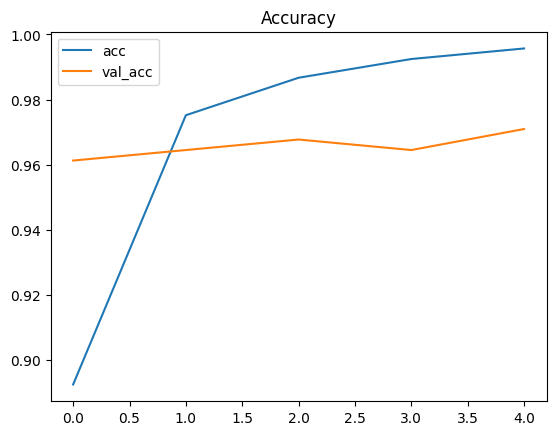

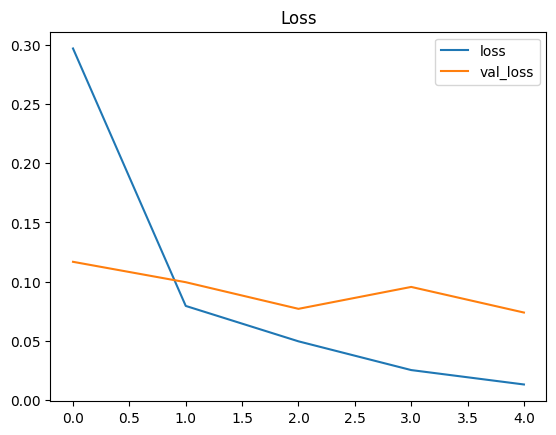

In [29]:
history_df[['acc','val_acc']].plot(title='Accuracy')
history_df[['loss','val_loss']].plot(title='Loss')

In [ ]:
loss,acc = model.evaluate(X_test,test['Status'])
acc

In [32]:
# model.save('99_accuracy_lstm')
model.save('99_accuracy_lstm_new2.h5')

In [ ]:
# newinput = ["I hope {{Name}} was able to translate your expectations into a reality. We can jump on another call to go through these and collect any feedback. I was also curious about a separate project you discussed which was more suitable for {{Name}}. Would you like to get started there?"]
# newinput = ["Hi, Rohan! We've heard your feedback, and we're excited to announce the return of our unlimited plan! Thanks to our amazing community, we're empowering you to write as much as you want without worrying about usage costs or how many words you have left. With our unlimited plan, you'll get: Unlimited access to Blog Post Wizard and 90+ writing and creativity tools Four extra seats for your team Translation support to help you reach a global audience Regular updates, priority customer support, and early access to new features Three months free with an annual plan Upgrade today and save an additional 25% with our annual plan!"]
# newinput = ["Your support is greatly appreciated. I will also share the recording and transcript of the call after the end of the session."]

In [30]:
test_df = pd.read_csv("TestData.csv",header=None,encoding='cp1252')
test_df.columns = headers
original_data = test_df
check = test_df['Text'].apply(lambda x : clean(x))
testing_data = token.texts_to_sequences(check)
testing_data = pad_sequences(testing_data,padding='pre',truncating='pre',maxlen=max_len)

In [31]:
loss,acc = model.evaluate(X_test,y_test)
acc

10/10 [==============================] - 0s 8ms/step - loss: 0.0738 - acc: 0.9710


0.9709677696228027

In [ ]:
type(check[0])

In [ ]:
loss,acc = model.evaluate(testing_data,original_data['Status'])
acc

In [ ]:
# nn = '''Hi Jeff,
# I found your company on Indeed, on the Web and love the direction of your company.
# We're an ex-Google team in Silicon Valley who have executed projects for Airware, Cape, Vantage Robotics, The league and over 100 other companies. Our RapidResponse program puts our engineers on your project within 72 hours, thus as much as increasing productivity 200% within 30-days of joining the project; all of our team members have been verified by our ex-Google core team of engineers in San Francisco, California, and are ready to join your project today.
# Our team specializes in four key areas of development, including –
# 1. Full-stack engineering
# 2. Back-end engineering
# 3. Data science
# 4. Mobile engineering
# You can explore our engineering work: 
# Punch Engineering Services 
# I'd like to discuss a 90-day pilot of our RapidResponse program, once again our ex-Google, verified engineering team can get started on your project in as little as 72 hours notice. 
# How's your calendar any morning this week for a call?
# '''
# nn = '''Hi Randy,
# Apologies for the late response, this email somehow ended up in my spam.
# Can we schedule a call for early next week?
# Please let me know your availability, I'll send the invites accordingly.
# Thanks,'''
# nn ='''Hi Matthewdaddino,
# We've seen many times where a current engineering team may not be meeting expectations. If this is true with your team, we've created a Project Hand Off Checklist where our ex-Google team will take over and begin executing your project within 1-week of handoff and we will turn the ship around.
# We've developed digital products for SugarCRM, Google, PocketGems, Airware, Cape, Marie Kondo, and over 70+ other startups around the world, and we'd like to do the same for MAKERS NUTRITION.
# James Gutierrez, CEO of Insikt, said "Punch delivers, plain and simple."
# In our Project Hand Off Checklist, we will make sure we don't miss anything, including code documentation, hosting, codebase requirements, versioning access, administration, testing, and data dumps.
# <image002.png>
#  Once handoff to our Punch team is complete, you will see a proven, tested engineering process that will quickly execute and exceed your expectations. 
# Take a look at our engineering process here: 
# Punch Engineering Services 
# Let's have a quick call to review our Project Hand Off Program with you. How's your calendar this week or the next?
# Have a great day.'''
# nn ='''Verdi,
# When would you like to speak? I am available all day tomorrow.'''
# nn = '''Hello Susanne,
# I found your job posting on Glassdoor looking for a AWS Application Development Specialist and love the direction of your company!
# Our Platform Shadow Program pairs our AWS Certified Engineers with yours 1-1 to achieve higher site reliability and expand platform support to a 16 or 24 hour cycle.
# We can typically get our Platform Shadow Program kicked off in 24 - 48 hours from confirmation and close.
# Can we discuss next Monday at 2PM EST? Otherwise feel free to email me back or schedule here.
# Looking forward.'''
nn ='''Hi Reviews, 
I found you onGlassdoor looking for a CustomerServices Representative II and wanted to reach out and discuss how our Outsourced Customer Service Solution can help transform your service organization for the better. 
Punch is an ex-Disney/Google trained customer service team that helps customers expand their service capabilities.
We’ve worked with Comcast, Domino’s Pizza, Dish Networks, Charter Communications & Bit Defender to reduce customer churn and increase retention via Great Service. These projects included both technical & customer support.
Working with us offers the following benefits:
We can augment services to 16-or-24 hours
We’re multilingual and can enable multilingual support
Trained in popular software already
E-mail, Phone, Chat, and Social support ready
Our average first-call resolution rate > 86%
Our average minimum call time < 5.26 minutes
I’d love to show what we can do for The Windows Club via expanding support hours, introducing new support languages, establishing new support channels, and augmenting existing support efforts.
Can we jump on a quick call to discuss your customer support needs? Book a meeting with me here. 
Cheers,'''
nn='''Hi Reviews,
I found you onGlassdoor looking for a CustmerServices Representatic II and wanted to reach out and discuss how out Outsourced         customer service solution can help trasnform your service organization for the better.
We have worked with comcast, dominos pizza dish networks charter communications and bit defender to reduce customer churn and uincrease retentionv via'''
nn ='''Rohan Tahir made 1 update. Xouno/XOUN-241 Sales / Non sales Modal'''
nn ='''From:
"Zaid Jamshaid (Jira)"
Last Conversation :
1/25/2023, 4:33:56 PM
Mailbox :
rafaymahmood@punch.cool

Abdullah Yasir made 2 updates.
  /  	
BLOOM Testing
	Abdullah Yasir 4:30 PM PKT
Remaining Estimate:	0 minutes → 2 days

Original estimate:	2 days

Get Jira notifications on your phone! Download the Jira Cloud app for Android or iOS.

Manage notifications  •  Give feedback  •  Privacy policy
 


'''

# nn ='''Anytime Tuesday the 23rd should work.'''
nn='''Hey Steve,

I wanted to check back in on BiGDUG and its E-commerce strategy -

We're an E-Commerce UI/UX expert team based in Silicon Valley and New York that specializes in reducing cart abandonment and increasing the average order size per customer.

Our UI/UX efforts focus on the analysis of cart shopping behavior and A-B test various cart mechanisms to improve overall cart performance.
 
We have successfully executed multiple large-scale E-Commerce projects, including our work with LikeTwice.com (acquired by eBay) to drastically increase the average revenue per customer by 16%.
 
gif

I'd like to set up a quick call to discuss your current e-commerce program and compare notes on how we may be able to help leverage our expertise to drive ROI.

Let's meet this Thursday to discuss.

Book a meeting

Cheers.'''

In [ ]:
# testt = []
# testt.append(nn)
# for i in testt:
#     i = clean(i)
#     print(i)

testt = token.texts_to_sequences([nn])
testt = pad_sequences(testt,padding='pre',truncating='pre',maxlen=max_len)

In [ ]:
# for i in testt:
B = np.reshape(testt, (-1, testt.size))
result = model.predict(B)
print(round(result[0][0]))


In [ ]:
# testt = []
# test.append(nn)
# for i in testt:
#     i = clean(i)
#     print(i)
    
testt = token.texts_to_sequences([nn])
testt = pad_sequences(testt,padding='pre',truncating='pre',maxlen=max_len)

In [ ]:
nn

In [ ]:
def new_function()
    for x in range(0,len(pop)):
        if catch == 'Email Sales':
            go.append(qq[1])

In [ ]:
def function()
    for i in testing_data:
        B = np.reshape(i.(-1,i.size))
        result = model.predict(B)
        lstm_results.append(round(output[0][0]))
        print(round(output[0][0]))

In [ ]:
lstm_results = []

In [ ]:
for i in testing_data:
    B = np.reshape(i, (-1, i.size))
    result = model.predict(B)
    lstm_results.append(round(result[0][0]))
    print(round(result[0][0]))


In [ ]:
original_data['LSTM_Results'] = lstm_results

In [ ]:
original_data['LSTM_Results']

In [ ]:
import requests

API_URL = "http://103.217.176.165/api/sales"


def query(payload):
    response = requests.post(API_URL, json=payload)
    return response.json()


In [ ]:
api_Data = pd.read_csv("TestData.csv",header=None,encoding='cp1252')
api_Data.columns = headers
original_data2 = api_Data
check2 = api_Data['Text'].apply(lambda x : clean(x))

In [ ]:
api_Data = pd.read_csv("TestData.csv",header=None,encoding='cp12522')
api_Data.columns = headers

In [ ]:
for i in check2:
    a = query({
        "input":i
    })
    api_data.append(a['output'])
    print(a['output'])
    

In [ ]:
api_data

In [ ]:
original_data['API_RESULTS'] = api_data

In [ ]:
original_data

In [ ]:
original_data.to_csv("LSTM-Updated-Results.csv", encoding='utf-8')

In [ ]:
# update = df.read_csv("TestData.csv")

In [ ]:
# newinput = token.texts_to_sequences(newinput)
# newinput = pad_sequences(newinput,padding='pre',truncating='pre',maxlen=max_len)
# result = model.predict(newinput)
# result

In [ ]:
# Input:var cards = ['Jack', 8, 2, 6, 'King', 5, 3, 'Queen']
# Output:Requried Output = [2,3,5,6,8,'Jack','Queen','King']
# Explanation:Sort the array

In [ ]:
type(cards[1])